In [2]:
Weeimport numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import inv
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython import display
from tqdm import tqdm

# Advection Diffusion Equation
Consider the concentration of a material in a 1D space where the concentration at point $x$ and time $t$ is given by $u(x, t)$. The advection diffusion equation describing the change in concentration over time is given by

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} - v \frac{\partial u}{\partial x}$$

where at first we consider the source term $s(x, t) = 0, \forall x, t$.

First, let's apply a <i>Forward Finite Difference Scheme</i> to the time derivative 

$$\frac{\partial u}{\partial t} = \frac{u_j^{t+1}-u_j^{t}}{\Delta t}$$

Next, apply a <i>Crank-Nicolson Finite Difference Scheme</i> to the <b>diffusion</b> term

$$D \frac{\partial^2 u}{\partial x^2} = \frac{D}{2 \Delta x^2} ((u_{j+1}^{t+1} - 2u_{j}^{t+1} + u_{j-1}^{t+1})+(u_{j+1}^{t} - 2u_{j}^{t} + u_{j-1}^{t})$$

Lastly, let's apply an <i>Order 4 Central Finite Difference Scheme</i> to the <b>advection</b> term

$$v \frac{\partial u}{\partial x} = \frac{-u_{j+2}^t+8u_{j+1}^t-8u_{j-1}^t+u_{j-2}^t}{12}$$

Putting all of this together we get the following equation

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} - v \frac{\partial u}{\partial x} \\ \frac{u_j^{t+1}-u_j^{t}}{\Delta t} = \frac{D}{2 \Delta x^2} ((u_{j+1}^{t+1} - 2u_{j}^{t+1} + u_{j-1}^{t+1})+(u_{j+1}^{t} - 2u_{j}^{t} + u_{j-1}^{t}) - \frac{v}{12}(-u_{j+2}^t+8u_{j+1}^t-8u_{j-1}^t+u_{j-2}^t)$$

Which simplifies to the following when we move all $u^{t+1}$ terms to the left

$$\frac{-D \Delta t}{2 \Delta x^2}(u_{j+1}^{t+1} + u_{j-1}^{t+1}) + (1 + \frac{\Delta t D}{\Delta x^2}) u_j^{t+1}$$

And which simplifies to the following when we move all $u^t$ terms to the right.

$$-u_{j+2}^t\left(- \frac{v \Delta t}{12}\right) + u_{j+1}^t\left(\frac{D \Delta t}{2 \Delta x^2} + \frac{8v \Delta t}{12}\right) - u_j^t (\frac{D \Delta t}{\Delta x^2}) + u_{j-1}^t (\frac{D \Delta t}{2 \Delta x^2} - \frac{8v \Delta t}{12}) + u_{j-2}^{t}(\frac{v \Delta t}{12})$$

We can describe this equation with the following matrix equation

$$B \boldsymbol{u_{t+1}} = C \boldsymbol{u_t}$$

Where $\boldsymbol{u_{t+1}} = [u_0^{t+1}, \dots, u_i^{t+1}, \dots, u_n^{t+1}]$ and $\boldsymbol{u_{t}} = [u_0^{t}, \dots, u_i^{t}, \dots, u_n^{t}]$.

Finally, I'm all out of LaTEX energy, but the diaganols of the $B$ and $C$ matrices correspond to the coefficient in front of each $u$ term.

## Advection Only

100000 time steps


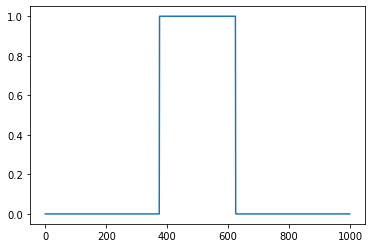

In [28]:
# Define the spatial domain
x_start = -1
x_end = 1
x = x_end - x_start
Nx = 1000
dx = x / Nx

# Define the temporal domain
# max_dt = max_stable_timestep(dx, D)
# print(max_dt)
dt = 1e-4
time_bounds = [0, 10]
Nt = int((time_bounds[1] - time_bounds[0]) / dt)
print(f'{Nt} time steps')

# Define model parameters
theta = 0.5
D = 0
v = -1

# Create system of linear equations from the model parameters
b0 = 1 + ((2 * theta * D * dt)/dx**2)
b_ = (-theta * D * dt) / dx**2
B = sparse.diags([b_, b0, b_], [-1, 0, 1], shape=[Nx, Nx])
B = sparse.csc_matrix(B)

c0 = 1 - (2*(1-theta)*D*dt)/dx**2
c_ = ((2*(1-theta)*D*dt)/dx**2) - (8*v*dt/12)
c__ = v*dt/12
c_1 = ((8*v*dt)/12) + (((1-theta)*D*dt)/dx**2)
c_2 = -v*dt/12
C = sparse.diags([c__, c_, c0, c_1, c_2], [-2, -1, 0, 1, 2], shape=[Nx, Nx])
C = sparse.csc_matrix(C)

# Define initial conditions and boundary conditions
u = np.zeros([Nx, Nt])
u[(3*Nx)//8:(5*Nx)//8, 0] = 1
u[0, 0] = 0.
u[-1, 0] = 0.
plt.plot(u[:, 0])
plt.show()

In [29]:
time_elapsed = time_bounds[0]
B_inv = inv(B)
BC = B_inv @ C

pbar_model = tqdm(total=(Nt-1), position=0)
for i in range(Nt-1):
    # Do a forward time step
    u[:, i+1] = BC @ u[:, i]

    # Enforce the boundary conditions
    u[0, i+1] = 0.
    u[-1, i+1] = 0.
    pbar_model.update(1)
pbar_model.close()

100%|██████████████████████████████████| 99999/99999 [00:03<00:00, 28051.34it/s]


In [30]:
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), u[:, 0])
ax.set_ylim([-0.01, 1.1])
step_factor = Nt//100

def animate(i):
    i *= step_factor
    line.set_ydata(u[:, i])
    pbar_anim.update(1)
    return line,
    
frames = (u.shape[1] - 1) // step_factor
pbar_anim = tqdm(total=frames, position=0)
anim = FuncAnimation(fig, animate, interval=25, frames=frames, repeat=False, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

101it [00:24,  4.15it/s]                                 | 0/99 [00:00<?, ?it/s]
100%|███████████████████████████████████████████| 99/99 [00:02<00:00, 34.93it/s]

## With Diffusion

In [11]:
# Define the spatial domain
x_start = -1
x_end = 1
x = x_end - x_start
Nx = 100
dx = x / Nx

# Define the temporal domain
# max_dt = max_stable_timestep(dx, D)
# print(max_dt)
dt = 1e-4
time_bounds = [0, 10]
Nt = int((time_bounds[1] - time_bounds[0]) / dt)

# Define model parameters
theta = 0.5
D = 0.1
v = -1

# Create system of linear equations from the model parameters
b0 = 1 + ((2 * theta * D * dt)/dx**2)
b_ = (-theta * D * dt) / dx**2
B = sparse.diags([b_, b0, b_], [-1, 0, 1], shape=[Nx, Nx])
B = sparse.csc_matrix(B)

c0 = 1 - (2*(1-theta)*D*dt)/dx**2
c_ = ((2*(1-theta)*D*dt)/dx**2) - (8*v*dt/12)
c__ = v*dt/12
c_1 = ((8*v*dt)/12) + (((1-theta)*D*dt)/dx**2)
c_2 = -v*dt/12
C = sparse.diags([c__, c_, c0, c_1, c_2], [-2, -1, 0, 1, 2], shape=[Nx, Nx])
C = sparse.csc_matrix(C)

# Define initial conditions and boundary conditions
u = np.zeros([Nx, Nt])
u[(3*Nx)//8:(5*Nx)//8, 0] = 1
u[0, 0] = 0.
u[-1, 0] = 0.

time_elapsed = time_bounds[0]
B_inv = inv(B)
BC = B_inv @ C

pbar_model = tqdm(total=(Nt-1), position=0)
for i in range(Nt-1):
    # Do a forward time step
    u[:, i+1] = BC @ u[:, i]

    # Enforce the boundary conditions
    u[0, i+1] = 0.
    u[-1, i+1] = 0.
    pbar_model.update(1)
pbar_model.close()

100%|██████████████████████████████████| 99999/99999 [00:02<00:00, 49330.34it/s]


In [12]:
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), u[:, 0])
ax.set_ylim([-0.01, 1.1])
step_factor = Nt//100

def animate(i):
    i *= step_factor
    line.set_ydata(u[:, i])
    pbar_anim.update(1)
    return line,
    
frames = (u.shape[1] - 1) // step_factor
pbar_anim = tqdm(total=frames, position=0)
anim = FuncAnimation(fig, animate, interval=25, frames=frames, repeat=False, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

101it [01:51,  1.11s/it]                                 | 0/99 [00:00<?, ?it/s]
101it [00:02, 38.16it/s]                                                        

101it [00:20, 38.16it/s]

# Try to improve advective stability by using an upwind forward difference

In [41]:
# Define the spatial domain
x_start = -1
x_end = 1
x = x_end - x_start
Nx = 1000
dx = x / Nx

# Define the temporal domain
# max_dt = max_stable_timestep(dx, D)
# print(max_dt)
dt = 1e-4
time_bounds = [0, 10]
Nt = int((time_bounds[1] - time_bounds[0]) / dt)
print(f'{Nt} time steps')

# Define model parameters
theta = 2
D = 0
v = -1

# Create system of linear equations from the model parameters
b0 = 1 + ((2 * theta * D * dt)/dx**2)
b_ = (-theta * D * dt) / dx**2
B = sparse.diags([b_, b0, b_], [-1, 0, 1], shape=[Nx, Nx])
B = sparse.csc_matrix(B)

# Wave is moving right (F.D. backwards)
# if v <= 0:
c0 = 1 - ((2*(1-theta)*D*dt)/dx**2) + ((11/6)*v*dt)   
c_l_1 = ((2*(1-theta)*D*dt)/dx**2) - (3*v*dt)
c_l_2 = (3/2)*v*dt
c_l_3 = (-1/3)*v*dt
c_r_1 = (((1-theta)*D*dt)/dx**2)
C = sparse.diags([c_l_3, c_l_2, c_l_1, c0, c_r_1], [-3, -2, -1, 0, 1], shape=[Nx, Nx])

# c0 = 1 - (2*(1-theta)*D*dt)/dx**2
# c_ = ((2*(1-theta)*D*dt)/dx**2) - (8*v*dt/12)
# c__ = v*dt/12

# c_1 = ((8*v*dt)/12) + (((1-theta)*D*dt)/dx**2)
# c_2 = -v*dt/12
# C = sparse.diags([c__, c_, c0, c_1, c_2], [-2, -1, 0, 1, 2], shape=[Nx, Nx])
C = sparse.csc_matrix(C)

# Define initial conditions and boundary conditions
u = np.zeros([Nx, Nt])
u[(3*Nx)//8:(5*Nx)//8, 0] = 1
u[0, 0] = 0.
u[-1, 0] = 0.

100000 time steps


In [42]:
time_elapsed = time_bounds[0]
B_inv = inv(B)
BC = B_inv @ C

pbar_model = tqdm(total=(Nt-1), position=0)
for i in range(Nt-1):
    # Do a forward time step
    u[:, i+1] = BC @ u[:, i]

    # Enforce the boundary conditions
    u[0, i+1] = 0.
    u[-1, i+1] = 0.
    pbar_model.update(1)
pbar_model.close()

100%|██████████████████████████████████| 99999/99999 [00:02<00:00, 35668.74it/s]


In [43]:
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), u[:, 0])
ax.set_ylim([-0.01, 1.1])
step_factor = Nt//100

def animate(i):
    i *= step_factor
    line.set_ydata(u[:, i])
    pbar_anim.update(1)
    return line,
    
frames = (u.shape[1] - 1) // step_factor
pbar_anim = tqdm(total=frames, position=0)
anim = FuncAnimation(fig, animate, interval=25, frames=frames, repeat=False, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

101it [19:06, 11.36s/it]                                 | 0/99 [00:00<?, ?it/s]
100it [00:02, 37.72it/s]                                                        

# Advection - Diffusion Crank-Nicolson Method Both Terms

10000 time steps


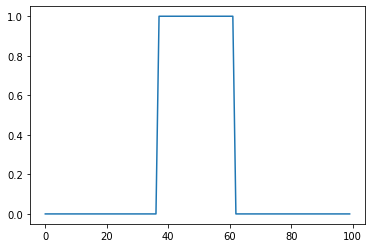

In [128]:
# Define the spatial domain
x_start = 0
x_end = 1
x = x_end - x_start
Nx = 100
dx = x / Nx

# Define the temporal domain
# max_dt = max_stable_timestep(dx, D)
# print(max_dt)
dt = 1e-3
time_bounds = [0, 10]
Nt = int((time_bounds[1] - time_bounds[0]) / dt)
print(f'{Nt} time steps')

# Define model parameters
D = 0.001
v = 1

# Create system of linear equations from the model parameters
lamda = (D * dt) / (2 * dx**2)
alpha = (v * dt) / (4 * dx)

b0 = (1 + 2 * lamda)
b_l_1 = (-alpha - lamda)
b_r_1 = (alpha - lamda)
B = sparse.diags([b_l_1, b0, b_r_1], [-1, 0, 1], shape=[Nx, Nx])
B = sparse.csc_matrix(B)

c0 = (1 - 2*lamda)
c_l_1 = (lamda + alpha)
c_r_1 = (lamda - alpha)

C = sparse.diags([c_l_1, c0, c_r_1], [-1, 0, 1], shape=[Nx, Nx])
C = sparse.csc_matrix(C)

# Define initial conditions and boundary conditions
bc = 0.
u = np.zeros([Nx, Nt])
u[(3*Nx)//8:(5*Nx)//8, 0] = 1
u[0, 0] = bc
u[-1, 0] = bc
plt.plot(u[:, 0])
plt.show()

In [129]:
time_elapsed = time_bounds[0]
B_inv = inv(B)
BC = B_inv @ C

pbar_model = tqdm(total=(Nt-1), position=0)
for i in range(Nt-1):
    # Do a forward time step
    u[:, i+1] = BC @ u[:, i]

    # Enforce the boundary conditions
    # u[0, i+1] = bc
    # u[-1, i+1] = bc
    u[0, i+1], u[-1, i+1] = u[-1, i+1], u[0, i+1]
    
    pbar_model.update(1)
pbar_model.close()

100%|████████████████████████████████████| 9999/9999 [00:00<00:00, 51409.25it/s]


In [130]:
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), u[:, 0])
ax.set_ylim([-0.01, 1.1])
step_factor = Nt//100
window = Nt//2

def animate(i):
    # i *= step_factor
    line.set_ydata(u[:, i])
    pbar_anim.update(1)
    return line,
    
frames = (u.shape[1] - 1) // step_factor
pbar_anim = tqdm(total=frames, position=0)
anim = FuncAnimation(fig, animate, interval=25, frames=frames, repeat=False, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

101it [00:11,  8.73it/s]                                 | 0/99 [00:00<?, ?it/s]
101it [00:02, 37.46it/s]                                                        

# More Diffusion

10000 time steps


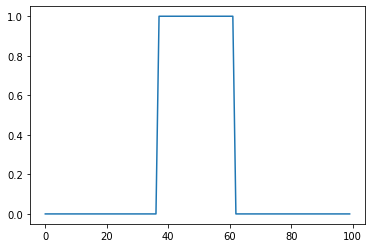

In [139]:
# Define the spatial domain
x_start = 0
x_end = 1
x = x_end - x_start
Nx = 100
dx = x / Nx

# Define the temporal domain
# max_dt = max_stable_timestep(dx, D)
# print(max_dt)
dt = 1e-3
time_bounds = [0, 10]
Nt = int((time_bounds[1] - time_bounds[0]) / dt)
print(f'{Nt} time steps')

# Define model parameters
D = 0.05
v = 1

# Create system of linear equations from the model parameters
lamda = (D * dt) / (2 * dx**2)
alpha = (v * dt) / (4 * dx)

b0 = (1 + 2 * lamda)
b_l_1 = (-alpha - lamda)
b_r_1 = (alpha - lamda)
B = sparse.diags([b_l_1, b0, b_r_1], [-1, 0, 1], shape=[Nx, Nx])
B = sparse.csc_matrix(B)

c0 = (1 - 2*lamda)
c_l_1 = (lamda + alpha)
c_r_1 = (lamda - alpha)

C = sparse.diags([c_l_1, c0, c_r_1], [-1, 0, 1], shape=[Nx, Nx])
C = sparse.csc_matrix(C)

# Define initial conditions and boundary conditions
bc = 0.
u = np.zeros([Nx, Nt])
u[(3*Nx)//8:(5*Nx)//8, 0] = 1
u[0, 0] = bc
u[-1, 0] = bc
plt.plot(u[:, 0])
plt.show()

In [140]:
time_elapsed = time_bounds[0]
B_inv = inv(B)
BC = B_inv @ C

pbar_model = tqdm(total=(Nt-1), position=0)
for i in range(Nt-1):
    # Do a forward time step
    u[:, i+1] = BC @ u[:, i]

    # Enforce the boundary conditions
    # u[0, i+1] = bc
    # u[-1, i+1] = bc
    u[0, i+1], u[-1, i+1] = u[-1, i+1], u[0, i+1]
    
    pbar_model.update(1)
pbar_model.close()

100%|████████████████████████████████████| 9999/9999 [00:00<00:00, 51201.57it/s]


In [141]:
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), u[:, 0])
ax.set_ylim([-0.01, 1.1])
step_factor = Nt//100
window = Nt//2

def animate(i):
    # i *= step_factor
    line.set_ydata(u[:, i])
    pbar_anim.update(1)
    return line,
    
frames = (u.shape[1] - 1) // step_factor
pbar_anim = tqdm(total=frames, position=0)
anim = FuncAnimation(fig, animate, interval=25, frames=frames, repeat=False, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

101it [00:10,  9.35it/s]                                 | 0/99 [00:00<?, ?it/s]
101it [00:02, 37.92it/s]                                                        

101it [00:15, 37.92it/s]